<a href="https://colab.research.google.com/github/yeb2Binfang/DS_GY_3001_CV/blob/main/HW/HW2/Canny_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2: Canny edge detector

The goal of the assignment is to implement a Canny edge detector. You should return the completed notebook, including answers and illustrations. 

If you are using [anaconda](https://www.anaconda.com/distribution/) you will have necessary libraries, if not, you may need to install them.

--2021-03-13 20:01:58--  https://raw.githubusercontent.com/yeb2Binfang/DS_GY_3001_CV/main/HW/HW2/lena.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105764 (103K) [image/jpeg]
Saving to: ‘lena.jpg’

lena.jpg            100%[===================>] 103.29K  --.-KB/s    in 0.01s   

2021-03-13 20:01:59 (6.86 MB/s) - ‘lena.jpg’ saved [105764/105764]



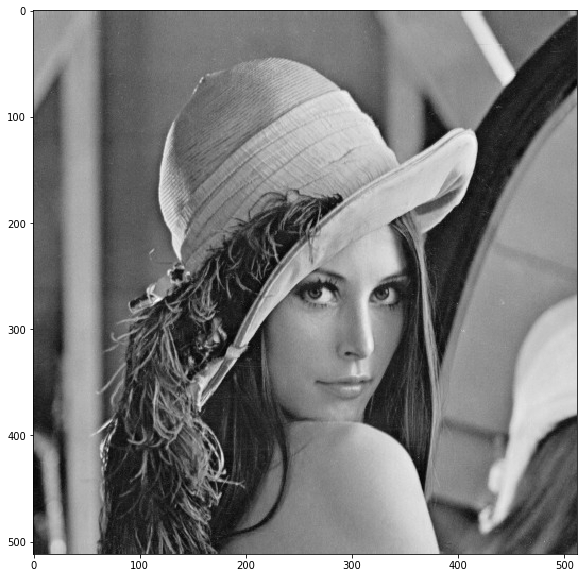

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import scipy.ndimage as ndimage #image processing library

# by default, the grayscale images are displayed with the jet colormap: use grayscale instead
plt.rcParams['image.cmap'] = 'gray'  

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray
!wget https://raw.githubusercontent.com/yeb2Binfang/DS_GY_3001_CV/main/HW/HW2/lena.jpg -O lena.jpg
name = 'lena.jpg'
img = plt.imread(name)
img = rgb2gray(img)
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(img)

## Step 1:
a- Compute a binary image corresponding to thresholding the norm of the gradient. You may use the function `ndimage.gaussian_filter` to compute the derivative of gaussian filter (see [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)). Discuss the parameters (there are two) and their influence on the results.

In [85]:
def compute_gradient(img,sigma,threshold):
    '''
    Inputs: input image, sigma and threshold parameter
    Outputs: g_norm - thresholded norm of the gradient, g_theta - gradient orientation
    '''
    # insert your code here
    Gx=ndimage.gaussian_filter(img, sigma, (0,1))
    Gy=ndimage.gaussian_filter(img, sigma, (1,0))
    g_norm = np.sqrt(Gx**2+Gy**2)
    g_norm = g_norm / g_norm.max()*255
    g_norm = (g_norm>=threshold) * g_norm

    g_theta = np.arctan2(Gy,Gx)


    return g_norm, g_theta



Sigma:larger sigma will make the final result lose many details. In addition, it will make the picture "loose" which means the edges are not fine but like "ink wash". If you set a small sigma like value 1, or 2, the final result will retain many details but looks a lot messy. Especially, it will remain some unnecessary edges.

threshold: It will reduce some less important edges. It will make the final result look less messy. However, if you set threshold as a large value, it will lose many edges or details. 

## Step 2:
b- Write a function `nms(g_norm,g_theta)` which takes as input the gradient norm and direction and outputs a binary images with value 1 only for pixels that correspond to a maximum in the direction of the gradient.

In [81]:
def non_max_suppression(g_norm, g_theta):
    '''
    Inputs: g_norm - thresholded norm of the gradient, g_theta - gradient orientation
    Outputs: I - image processed with non-max supression
    '''
    # insert your code here
    M, N = g_norm.shape

    Z = np.zeros(g_norm.shape)

    PI = 180

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            angle = g_theta[i, j]

            # (0 - PI/8 and 15PI/8 - 2PI)
            if (0 <= angle < PI / 8) or (15 * PI / 8 <= angle <= 2 * PI):
                q = g_norm[i, j - 1]
                r = g_norm[i, j + 1]

            elif (PI / 8 <= angle < 3 * PI / 8) or (9 * PI / 8 <= angle < 11 * PI / 8):
                q = g_norm[i + 1, j - 1]
                r = g_norm[i - 1, j + 1]

            elif (3 * PI / 8 <= angle < 5 * PI / 8) or (11 * PI / 8 <= angle < 13 * PI / 8):
                q = g_norm[i - 1, j]
                r = g_norm[i + 1, j]

            else:
                q = g_norm[i - 1, j - 1]
                r = g_norm[i + 1, j + 1]

            if g_norm[i, j] >= q and g_norm[i, j] >= r:
                Z[i, j] = g_norm[i, j]

    return Z



## Step 3:
c- Combine 'a' and 'b' to extract edges with a gradient norm larger than a given threshold.

In [77]:
def threshold(img,highThreshold,lowThreshold):
    '''
    Inputs: img - image processes with non-max supression, 
            highThreshold,lowThreshold - high and low threshodl ratios
    Outputs: res - output image, weak, strong - pixel values assiged to weak and strong images
    '''
    # insert your code here
    highThreshold = img.max() * highThreshold
    lowThreshold = highThreshold * lowThreshold
    M, N = img.shape
    res = np.zeros((M,N),dtype=np.int32)

    weak = 100
    strong = 255

    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res, weak, strong



## Step 4:
d- Add the hysteresis thresholding to step 'c' to implement a function computing the Canny edges.

Here is one way to do the hysteresis thresholding. Apply step c with two thresholds $t_1 < t_2$. This yields a set of "strong pixels" (large threshold) and "weak pixels" (small threshold). Initialize a list of edge pixels by including only the set of strong pixels. For each pixel in this list, check if its neighboors are weak pixels. If they are, add them to the list of pixels to visit.

In [79]:
def hysteresis(img, weak, strong):
    '''
    Inputs: res - thresholded NMS image, 
    weak, strong - pixel values assiged to weak and strong images
    
    Outputs: img - result after hysteresis
    '''

    # insert your code here
    M, N = img.shape 
    res = np.zeros((M,N)) 
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
              if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                  or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                  or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                  img[i, j] = strong
              else:
                  img[i, j] = 0
    
    
    return img



## Step 5:
e- Run your code on at least four images of your own choosing. Use different parameters and comment on their effects.

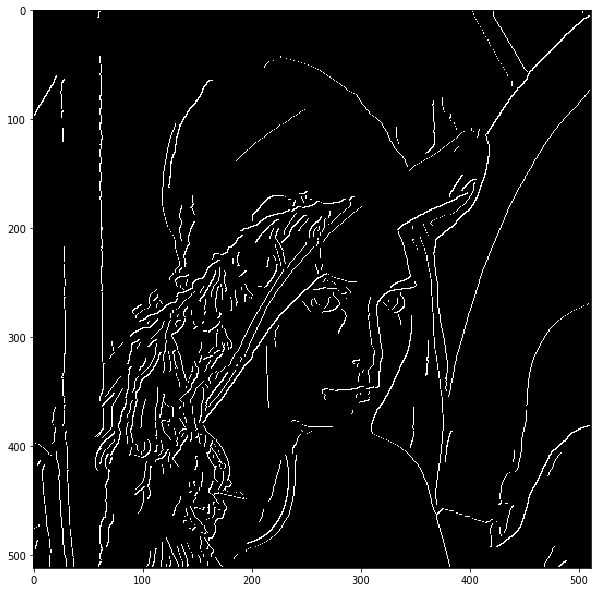

In [251]:
# parameters to check
sigma=2
lowThreshold=0.09
highThreshold=0.2
weak_pixel=100
strong_pixel=255


'''
gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)
'''
gradientMat, thetaMat = compute_gradient(img,sigma,0)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak,strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)

For lena picture, I set sigma=2, lowThreshold=0.09, highThreshold=0.2, threshold=0. Sigma value will help reduce some edges. If I set sigma=1, the hair part will look messy. But when sigma=2, the edges in hair part have more space. lowThreshold will identify the non-revelent edges and highThreshold will identify the strong pixels. Any pixel values between them will use hystersis to identify as strong or non-revelent. 

### chopper pic

In [95]:

!wget http://tv06.tgbusdata.cn/v3/thumb/jpg/YjcyNSw2MDAsNjAwLDQsMSwxLC0xLDAscms1MA==/u/pc.tgbus.com/uploads/allimg/150826/303-150R61SK6.jpg -O qiaoba.jpg

--2021-03-13 21:29:42--  http://tv06.tgbusdata.cn/v3/thumb/jpg/YjcyNSw2MDAsNjAwLDQsMSwxLC0xLDAscms1MA==/u/pc.tgbus.com/uploads/allimg/150826/303-150R61SK6.jpg
Resolving tv06.tgbusdata.cn (tv06.tgbusdata.cn)... 157.185.175.102
Connecting to tv06.tgbusdata.cn (tv06.tgbusdata.cn)|157.185.175.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘qiaoba.jpg’

qiaoba.jpg              [ <=>                ] 103.61K  --.-KB/s    in 0.05s   

2021-03-13 21:29:42 (1.90 MB/s) - ‘qiaoba.jpg’ saved [106095]



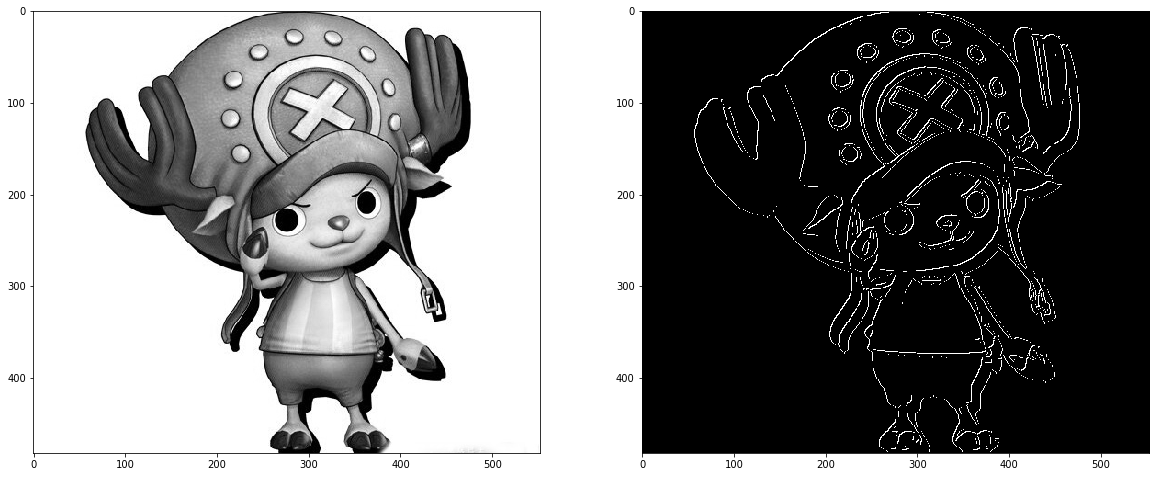

In [249]:
# parameters to check
sigma=1.3
lowThreshold=0.01
highThreshold=0.12
weak_pixel=100
strong_pixel=255

chopper = plt.imread('qiaoba.jpg')
chopper = rgb2gray(chopper)

gradientMat, thetaMat = compute_gradient(chopper,sigma,50)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak,strong)
plt.figure(figsize=(20, 40))
plt.subplot(121)
plt.imshow(chopper)
plt.subplot(122)
plt.imshow(img_final)

For chopper picture, I set sigma=1.3, lowThreshold=0.01, highThreshold=0.12, threshold=50. Sigma value cannot be too large in this picture because it will lose many details and the structure of this picture is very simple. However, if sigma is small, then it is necessary to threshold some unnecessary edges so that I set threshold = 50. 

### sanji pic

In [106]:

!wget http://n.sinaimg.cn/sinacn10117/740/w600h940/20190907/1a81-ieftthy3321490.png -O shanzhi.png

--2021-03-13 21:32:58--  http://n.sinaimg.cn/sinacn10117/740/w600h940/20190907/1a81-ieftthy3321490.png
Resolving n.sinaimg.cn (n.sinaimg.cn)... 23.59.188.99, 23.59.188.114
Connecting to n.sinaimg.cn (n.sinaimg.cn)|23.59.188.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 483250 (472K) [image/png]
Saving to: ‘shanzhi.png’

shanzhi.png         100%[===================>] 471.92K  --.-KB/s    in 0.03s   

2021-03-13 21:32:59 (17.9 MB/s) - ‘shanzhi.png’ saved [483250/483250]



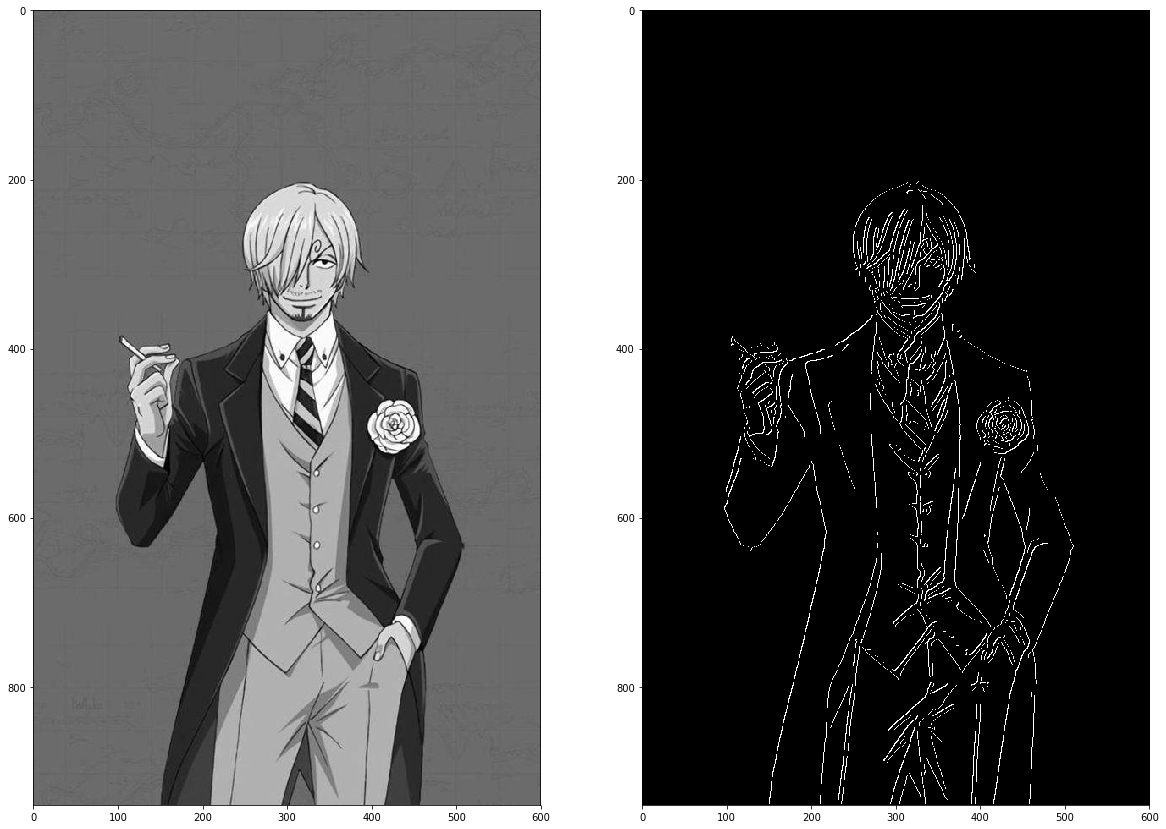

In [242]:
# parameters to check
sigma=2
lowThreshold=0.08
highThreshold=0.17
weak_pixel=100
strong_pixel=255

sanji = plt.imread('shanzhi.png')
sanji = rgb2gray(sanji)
'''
gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)
'''
gradientMat, thetaMat = compute_gradient(sanji,sigma,10)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak,strong)
plt.figure(figsize=(20, 40))
plt.subplot(121)
plt.imshow(sanji)
plt.subplot(122)
plt.imshow(img_final)

For snaji picture, I set sigma=2, lowThreshold=0.08, highThreshold=0.17, threshold=10. Keep lowThreshold constant, increasing highThreshold will lose details and edges. Keep highThreshold constant, decreasing lowThreshold will retain more details and edges. For this pic, we have to set lowThreshold and highThreshold values carefully since it is very easy to get discontinuous result.

### Nico Robin pic

In [211]:
!wget http://ekladata.com/v6OKtrhVoQ7Y-dC9po1IaySA6N4.jpg -O robin.jpg

--2021-03-13 22:23:01--  http://ekladata.com/v6OKtrhVoQ7Y-dC9po1IaySA6N4.jpg
Resolving ekladata.com (ekladata.com)... 212.83.152.79
Connecting to ekladata.com (ekladata.com)|212.83.152.79|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘robin.jpg’

robin.jpg               [   <=>              ] 247.40K   461KB/s    in 0.5s    

2021-03-13 22:23:02 (461 KB/s) - ‘robin.jpg’ saved [253336]



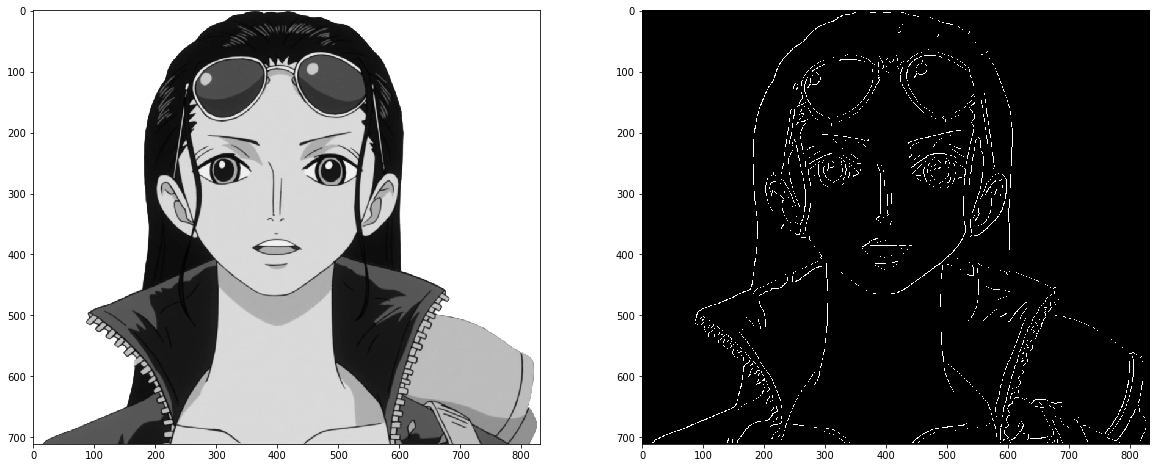

In [227]:
# parameters to check
sigma=3
lowThreshold=0.01
highThreshold=0.2
weak_pixel=100
strong_pixel=255

robin = plt.imread('robin.jpg')
robin = rgb2gray(robin)
'''
gradientMat, thetaMat = compute_gradient(img,sigma)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak, strong)
plt.figure(figsize=(10, 20))
plt.imshow(img_final)
'''
gradientMat, thetaMat = compute_gradient(robin,sigma,10)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak,strong)
plt.figure(figsize=(20, 40))
plt.subplot(121)
plt.imshow(robin)

plt.subplot(122)
plt.imshow(img_final)


For robin pic, I set sigma=3, lowThreshold=0.01, highThreshold=0.2, threshold=10.we should try to keep more details for zipper part. The shape of zipper is complicated. That's why I set lowThreshold and highThreshold not a large value. 

### cute Nico Robin

In [131]:

!wget http://5b0988e595225.cdn.sohucs.com/images/20191017/50fd6f0900544553ba6ecc47cf3f39d6.jpeg -O luobin.jpeg

--2021-03-13 21:42:15--  http://5b0988e595225.cdn.sohucs.com/images/20191017/50fd6f0900544553ba6ecc47cf3f39d6.jpeg
Resolving 5b0988e595225.cdn.sohucs.com (5b0988e595225.cdn.sohucs.com)... 211.152.148.29, 211.152.148.30, 211.152.148.44
Connecting to 5b0988e595225.cdn.sohucs.com (5b0988e595225.cdn.sohucs.com)|211.152.148.29|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15296 (15K) [image/jpeg]
Saving to: ‘luobin.jpeg’

luobin.jpeg         100%[===================>]  14.94K  --.-KB/s    in 0s      

2021-03-13 21:42:15 (237 MB/s) - ‘luobin.jpeg’ saved [15296/15296]



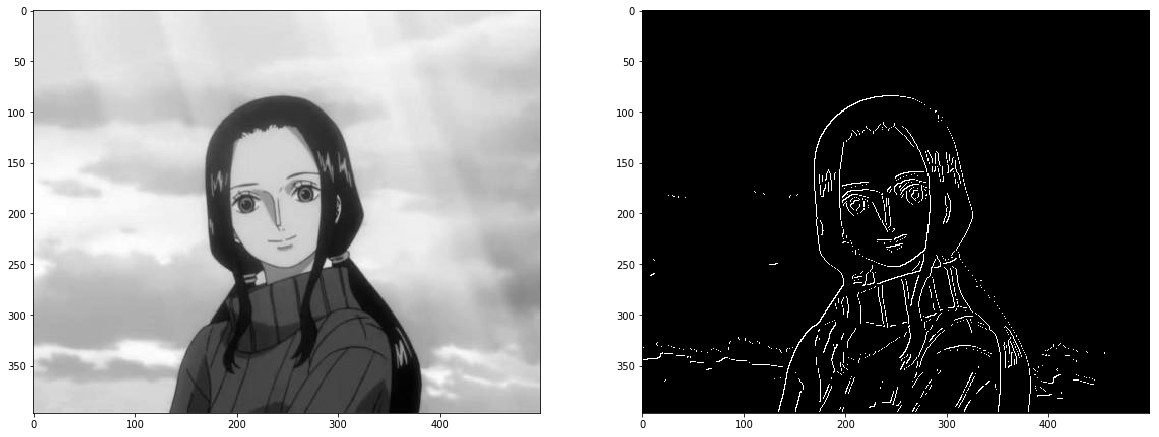

In [253]:
# parameters to check
sigma=1.2
lowThreshold=0.05
highThreshold=0.12
weak_pixel=100
strong_pixel=255

luobin = plt.imread('luobin.jpeg')
luobin = rgb2gray(luobin)

gradientMat, thetaMat = compute_gradient(luobin,sigma,30)
nonMaxImg = non_max_suppression(gradientMat, thetaMat)
thresholdImg, weak, strong = threshold(nonMaxImg,highThreshold,lowThreshold)
img_final = hysteresis(thresholdImg, weak,strong)
plt.figure(figsize=(20, 40))
plt.subplot(121)
plt.imshow(luobin)

plt.subplot(122)
plt.imshow(img_final)

For Nico Robin pic, I set sigma = 1.2, lowThreshold=0.05, highThreshold=0.12, and set threshold = 30. Large threshold value will get rid of the detailed egde on the cloth. We should keep more details for the cloth part. Also, small sigma will make the final result clearer.